In [133]:
# Import stuff

import pandas as pd;
from sklearn.model_selection import train_test_split;
from sklearn import ensemble;
from sklearn.metrics import mean_absolute_error;
import joblib;
import sys;

sys.path.append("../Shared")

# noinspection PyUnresolvedReferences
import helpers;
print_line = helpers.print_line;
notebook_print = helpers.notebook_print;

In [134]:
# Load the dataset

dataset = pd.read_csv("../Datasets/ml_house_data_set_updated.csv");

# Remove fields we do not want to include in our model

del dataset["house_number"];
del dataset["unit_number"];
del dataset["street_name"];
del dataset["zip_code"];

sale_price = dataset["sale_price"];

# Remove the sale price from the feature data ( Because we are trying to predict it )
del dataset["sale_price"];

features = dataset;

# Replace categorical data such as "garage_type" and "city" with one-hot encoded data
# https://stackoverflow.com/questions/77643432/why-is-pd-get-dummies-returning-boolean-values-instead-of-the-binaries-of-0-1
features = pd.get_dummies(features, columns=["garage_type", "city"], dtype=int);

print_line(features.columns);

notebook_print(features.head());

# Turn the data into numpy arrays

features = features.values;
sale_price = sale_price.values;

print(features);

Index(['year_built', 'stories', 'num_bedrooms', 'full_bathrooms',
       'half_bathrooms', 'livable_sqft', 'total_sqft', 'garage_sqft',
       'carport_sqft', 'has_fireplace', 'has_pool', 'has_central_heating',
       'has_central_cooling', 'garage_type_attached', 'garage_type_detached',
       'garage_type_none', 'city_Amystad', 'city_Brownport', 'city_Chadstad',
       'city_Clarkberg', 'city_Coletown', 'city_Davidfort', 'city_Davidtown',
       'city_East Amychester', 'city_East Janiceville', 'city_East Justin',
       'city_East Lucas', 'city_Fosterberg', 'city_Hallfort',
       'city_Jeffreyhaven', 'city_Jenniferberg', 'city_Joshuafurt',
       'city_Julieberg', 'city_Justinport', 'city_Lake Carolyn',
       'city_Lake Christinaport', 'city_Lake Dariusborough', 'city_Lake Jack',
       'city_Lake Jennifer', 'city_Leahview', 'city_Lewishaven',
       'city_Martinezfort', 'city_Morrisport', 'city_New Michele',
       'city_New Robinton', 'city_North Erinville', 'city_Port Adamtown',

,year_built,stories,num_bedrooms,full_bathrooms,half_bathrooms,livable_sqft,total_sqft,garage_sqft,carport_sqft,has_fireplace,...,city_South Anthony,city_South Stevenfurt,city_Toddshire,city_Wendybury,city_West Ann,city_West Brittanyview,city_West Gerald,city_West Gregoryview,city_West Lydia,city_West Terrence
0,1978,1,4,1,1,1689,1859,508,0,True,...,0,0,0,0,0,0,0,0,0,0
1,1958,1,3,1,1,1984,2002,462,0,True,...,0,0,0,0,0,0,0,0,0,0
2,2002,1,3,2,0,1581,1578,0,625,False,...,0,0,0,0,0,0,0,0,0,0
3,2004,1,4,2,0,1829,2277,479,0,True,...,0,0,0,0,0,0,0,0,0,0
4,2006,1,4,2,0,1580,1749,430,0,True,...,0,0,0,0,0,0,0,0,0,0


[[1978 1 4 ... 0 0 0]
 [1958 1 3 ... 0 0 0]
 [2002 1 3 ... 0 0 0]
 ...
 [1983 1 1 ... 0 0 0]
 [1981 1 3 ... 0 0 0]
 [1980 1 3 ... 0 0 0]]


In [135]:
# Split the data into training and testing sets

RANDOM_STATE = 69;

features_train, features_test, sale_price_train, sale_price_test = train_test_split(
    features,
    sale_price,
    train_size=0.8,
    random_state=RANDOM_STATE
);

gradiant_boosting_regressor = ensemble.GradientBoostingRegressor(
    n_estimators=1000, # Number of decision trees to build
    learning_rate=0.1, # How much each additional decision tree influences the final prediction
    max_depth=5, # How deep each decision tree can be
    min_samples_leaf=6, # Minimum number of samples required to be at a leaf node
    max_features=0.1, # Percentage of features to consider when looking for the best split
    loss="huber", # How to calculate the model's error
    random_state=RANDOM_STATE
);

gradiant_boosting_regressor.fit(features_train, sale_price_train);

In [136]:
# Export the trained model in pickle format
print_line("Exporting model...");

OUTPUT_DIRECTORY = "../Outputs";

MODEL_FILE_NAME = "gradient_boosting_regressor";

PICKLE_OUTPUT_PATH = f"{OUTPUT_DIRECTORY}/{MODEL_FILE_NAME}.pkl";
ONNX_OUTPUT_PATH = f"{OUTPUT_DIRECTORY}/{MODEL_FILE_NAME}.onnx";


joblib.dump(gradiant_boosting_regressor, PICKLE_OUTPUT_PATH);

print_line(f"Model saved to {PICKLE_OUTPUT_PATH}");

Exporting model...

Model saved to ../Outputs/gradient_boosting_regressor.pkl



In [137]:
# Export the trained model in ONNX format
# See: https://onnx.ai/sklearn-onnx/

from skl2onnx import to_onnx;
import numpy as np;

# Convert the first row of the training data to a float32 numpy array
features_test_onnx_input = features_train[0:1].astype(np.float32);

print_line(features_test_onnx_input);

onnx_model = to_onnx(
    model=gradiant_boosting_regressor,
    X=features_test_onnx_input,
    name="gradient_boosting_regressor"
);

onnx_graph = onnx_model.graph;
input_graph = onnx_graph.input;
output_graph = onnx_graph.output;

first_input_node = input_graph[0];
first_output_node = output_graph[0];

# https://imgur.com/a/0riFX4S
first_input_node.type.tensor_type.shape.dim[0].dim_param = "batch_size";
first_output_node.type.tensor_type.shape.dim[0].dim_param = "batch_size";

with open(ONNX_OUTPUT_PATH, "wb") as file_stream:
    file_stream.write(onnx_model.SerializeToString())

print_line(f"Model saved to {ONNX_OUTPUT_PATH}");

[[1.992e+03 1.000e+00 3.000e+00 1.000e+00 1.000e+00 1.340e+03 1.345e+03
  4.020e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]

Model saved to ../Outputs/gradient_boosting_regressor.onnx



In [138]:
# Verify the ONNX model against the actual model using the entire test set

import onnxruntime as rt;

onnx_session = rt.InferenceSession(ONNX_OUTPUT_PATH);

onnx_input_name = onnx_session.get_inputs()[0].name;
onnx_output_name = onnx_session.get_outputs()[0].name;

features_test_onnx_input = {onnx_input_name: features_test.astype(np.float32)};

predicted_sales_prices_onnx = onnx_session.run(None, features_test_onnx_input)[0].flatten();
predicted_sales_prices_actual = gradiant_boosting_regressor.predict(features_test);

print_line(predicted_sales_prices_onnx);
print_line(predicted_sales_prices_actual);

TOLERANCE = 0.001;

# Ensure the outputs are the same
assert np.allclose(
    predicted_sales_prices_onnx, predicted_sales_prices_actual,
    rtol=TOLERANCE,
    atol=TOLERANCE
);

[766022.8   130897.875 839288.75  ... 242616.66  516539.47  322602.   ]

[766022.74245116 130897.85124835 839288.93071926 ... 242616.65957996
 516539.45990132 322601.98378958]



In [139]:
# Evaluate the model

print_line("Evaluating the model...");

mean_absolute_error_result = mean_absolute_error(sale_price_test, predicted_sales_prices_actual);
print_line(f"Mean absolute error: {mean_absolute_error_result}");

mean_absolute_error_result = mean_absolute_error(sale_price_test, predicted_sales_prices_onnx);
print_line(f"Mean absolute error ( ONNX ): {mean_absolute_error_result}");

Evaluating the model...

Mean absolute error: 63984.96448216524

Mean absolute error ( ONNX ): 63984.963920354756



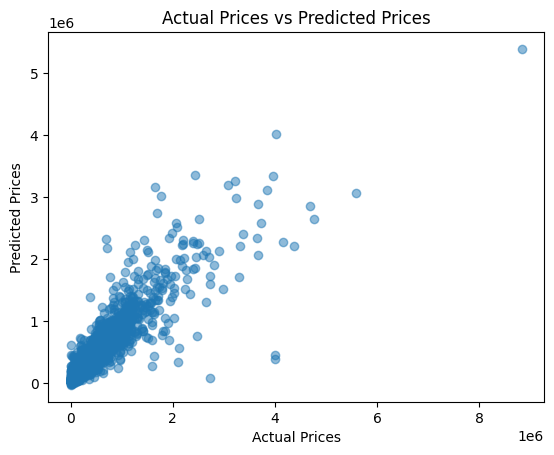

In [140]:
# Plot the results

import matplotlib.pyplot as plt;

plt.scatter(sale_price_test, predicted_sales_prices_actual, alpha=0.5);
plt.xlabel("Actual Prices");
plt.ylabel("Predicted Prices");
plt.title("Actual Prices vs Predicted Prices");